In [20]:
import numpy as np
import matplotlib.pyplot as plt

class AntColonyOptimization:
    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):
        self.distances = distances
        self.pheromone = np.ones(self.distances.shape) / len(distances)
        self.all_inds = range(len(distances))
        self.n_ants = n_ants
        self.n_best = n_best
        self.n_iterations = n_iterations
        self.decay = decay
        self.alpha = alpha
        self.beta = beta

    def run(self):
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)
        all_time_shortest_path_distances = []

        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths()
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path

            self.pheromone *= self.decay
            all_time_shortest_path_distances.append(all_time_shortest_path[1])

        return all_time_shortest_path, all_time_shortest_path_distances

    def gen_path_dist(self, path):
        total_dist = 0
        for ele in path:
            total_dist += self.distances[ele]
        return total_dist

    def gen_all_paths(self):
        all_paths = []
        for i in range(self.n_ants):
            path = self.gen_path(0)
            all_paths.append((path, self.gen_path_dist(path)))
        return all_paths

    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / (self.distances[move] + 1e-10)  # add a small value to avoid division by zero

    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move
            visited.add(move)
        path.append((prev, start))  # going back to where we started
        return path

    def pick_move(self, pheromone, dist, visited):
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0
        row = pheromone ** self.alpha * ((1.0 / (dist + 1e-10)) ** self.beta)  # add a small value to avoid division by zero

        if np.sum(row) == 0:
            row = np.ones_like(row)

        norm_row = row / np.sum(row)
        
        # Verify there are no NaNs in the probabilities
        if np.isnan(norm_row).any():
            norm_row = np.nan_to_num(norm_row)
            norm_row = norm_row / np.sum(norm_row)  # Renormalize

        move = np.random.choice(self.all_inds, 1, p=norm_row)[0]
        return move


In [80]:
# Carregar os dados do arquivo berlin52.tsp
coordinates = []
with open('berlin52.tsp') as f:
    for line in f.readlines()[6:-1]:
        parts = line.strip().split()
        coordinates.append((float(parts[1]), float(parts[2])))

n_cities = len(coordinates)
distances = np.zeros((n_cities, n_cities))
for i in range(n_cities):
    for j in range(n_cities):
        if i != j:
            distances[i][j] = np.linalg.norm(np.array(coordinates[i]) - np.array(coordinates[j]))

aco = AntColonyOptimization(distances, n_ants=1000, n_best=50, n_iterations=100, decay=0.99, alpha=1, beta=2)
shortest_path = aco.run()



In [81]:
sp = shortest_path[0]
sp_distances = shortest_path[1]

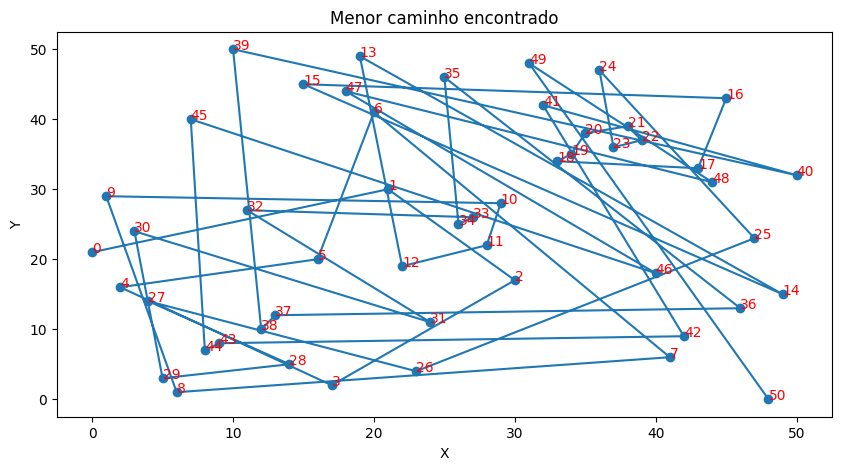

In [82]:

 # return to start
xs, ys = zip(*[s for s in sp[0]])
plt.figure(figsize=(10, 5))
# put number of each iteration
i = len(sp[0]) - 1
for j, txt in enumerate(sp[0]):
    plt.annotate(i, (xs[i], ys[i]), fontsize=10, color='red')
    i -= 1

    
plt.plot(xs, ys, marker='o')
plt.title('Menor caminho encontrado')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


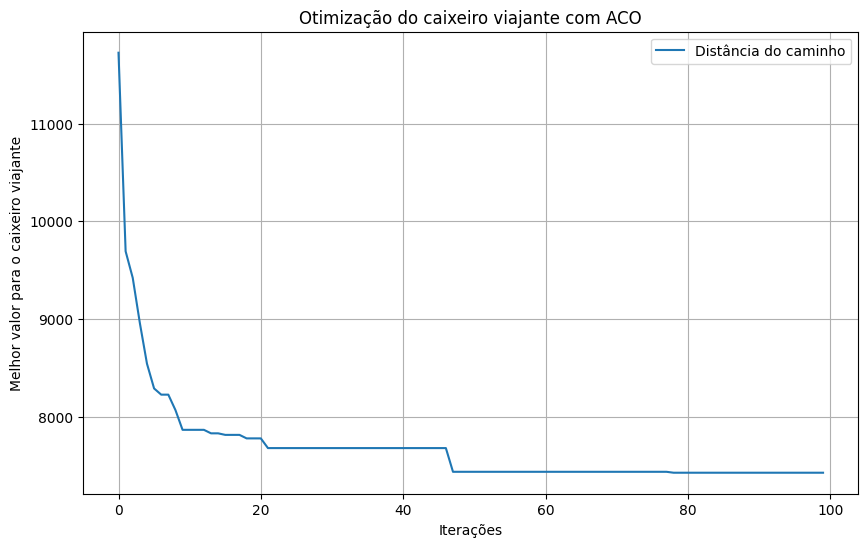

In [84]:

plt.figure(figsize=(10, 6))
plt.plot(sp_distances, label='Distância do caminho')
plt.legend()
# label the ult result
plt.xlabel('Iterações')
plt.ylabel('Melhor valor para o caixeiro viajante')
plt.title('Otimização do caixeiro viajante com ACO')
plt.grid(True)
plt.show()
